# Preprocessing CESM Breast Cancer Dataset

This notebook loads low energy and subtracted images, metadata, segmentation masks and medical reports for each patient.

In [305]:
import os
import cv2
import json
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [306]:
BASE_DIR = "CDD-CESM/PKG - CDD-CESM/CDD-CESM"
LE_IMAGE_DIR = os.path.join(BASE_DIR, "Low energy images of CDD-CESM")
SUB_IMAGE_DIR = os.path.join(BASE_DIR, "Subtracted images of CDD-CESM")
REPORT_DIR = "CDD-CESM/json_output"  # <- change this
XLSX_PATH = "CDD-CESM/Radiology-manual-annotations.xlsx"  # <- change this
MASK_DIR = "CDD-CESM/Radiology_hand_drawn_segmentations_v2.csv"  # <- change this
IMG_SIZE = (224, 224)

In [307]:
def load_image(image_name, image_type="LE", size=(224, 224)):
    print(f"Loading image: {image_name} of type {image_type}")
    if not image_name.endswith(".jpg"):
        image_name += ".jpg"
    if image_type == "LE":
        image_name = image_name.replace("CM", "DM")
    if image_type == "SUB":
        image_name = image_name.replace("DM", "CM")
    directory = LE_IMAGE_DIR if image_type == "LE" else SUB_IMAGE_DIR
    image_path = os.path.join(directory, image_name)
    if not os.path.exists(image_path):
        print(f"Image not found at {image_path}")
        raise FileNotFoundError(f"{image_path} not found.")
    else:
        print(f"Image found at {image_path}")
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    image = image / 255.0
    return image.astype(np.float32)

In [308]:
import pandas as pd
import numpy as np
import cv2
import json

def load_mask(image_name, csv_path="CDD-CESM/Radiology_hand_drawn_segmentations_v2.csv", size=(512, 512)):
    if not image_name.endswith(".jpg"):
        image_name += ".jpg"

    df = pd.read_csv(csv_path)

    # Filtrer les lignes correspondant à cette image
    rows = df[df["#filename"] == image_name]
    if rows.empty:
        print(f"No mask found for image: {image_name}")
        return np.zeros(size, dtype=np.float32)

    mask = np.zeros(size, dtype=np.uint8)

    for _, row in rows.iterrows():
        shape_str = row["region_shape_attributes"]
        if shape_str.strip() == "{}":
            continue

        try:
            shape = json.loads(shape_str)
            name = shape.get("name")

            if name == "ellipse":
                cx, cy = shape["cx"], shape["cy"]
                rx, ry = shape["rx"], shape["ry"]
                center = (int(cx), int(cy))
                axes = (int(rx), int(ry))
                cv2.ellipse(mask, center, axes, angle=0, startAngle=0, endAngle=360, color=255, thickness=-1)

            elif name == "circle":
                cx, cy = shape["cx"], shape["cy"]
                r = shape["r"]
                center = (int(cx), int(cy))
                cv2.circle(mask, center, int(r), color=255, thickness=-1)

            elif name == "polygon":
                # En cas de formes polygonales (par précaution)
                all_x = shape.get("all_points_x", [])
                all_y = shape.get("all_points_y", [])
                if all_x and all_y:
                    pts = np.array(list(zip(all_x, all_y)), np.int32).reshape((-1, 1, 2))
                    cv2.fillPoly(mask, [pts], 255)

        except Exception as e:
            print(f"Error parsing shape for {image_name}: {e}")

    mask = cv2.resize(mask, size)
    return (mask / 255.0).astype(np.float32)


In [309]:
def load_json_report(patient_id):
    path = os.path.join(REPORT_DIR, f"P{patient_id}.json")
    if not os.path.exists(path):
        print(f"JSON report not found for patient ID: {patient_id} at {path}")
        return ""
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

In [310]:
def load_metadata(xlsx_path):
    xl = pd.ExcelFile(xlsx_path)
    dfs = []
    for sheet in xl.sheet_names:
        df = xl.parse(sheet)
        df['source_sheet'] = sheet
        dfs.append(df)
    combined = pd.concat(dfs, ignore_index=True)
    return combined

In [311]:
metadata = load_metadata(XLSX_PATH)
cols_to_use = ['Image_name', 'Patient_ID', 'Side', 'Type', 'Age', 'ACR', 'BIRADS',
               'Findings', 'View', 'Machine', 'Pathology Classification/ Follow up']
metadata = metadata[[col for col in cols_to_use if col in metadata.columns]]
metadata = metadata.dropna(subset=['Image_name', 'Patient_ID'])
metadata['Age'] = pd.to_numeric(metadata['Age'], errors='coerce')
metadata['Age'] = metadata['Age'].fillna(metadata['Age'].median())
categorical_cols = ['Side', 'View', 'Machine']
ordinal_cols = ['ACR', 'BIRADS']
metadata = pd.get_dummies(metadata, columns=categorical_cols)
for col in ordinal_cols:
    metadata[col] = pd.to_numeric(metadata[col], errors='coerce')
    metadata[col] = metadata[col].fillna(0).astype(int)

In [312]:
def build_sample(row):
    img_name = row['Image_name']
    patient_id = row['Patient_ID']

    sample_data = {
        "image_le_L": None,
        "image_sub_L": None,
        "image_le_R": None,
        "image_sub_R": None,
        "mask_le_L": None,
        "mask_sub_L": None,
        "mask_le_R": None,
        "mask_sub_R": None,
        "report_text": "",
        "metadata": row
    }

    def load_both(image_name, image_type, mask_key, image_key):
        try:
            sample_data[image_key] = load_image(image_name, image_type=image_type)
            mask_filename = image_name + ".jpg" if not image_name.endswith(".jpg") else image_name
            sample_data[mask_key] = load_mask(mask_filename)
            print(f"Loaded {image_key} and {mask_key} for {image_name}")
        except FileNotFoundError:
            print(f"{image_key} or {mask_key} not found for {image_name}")
            sample_data[image_key] = None
            sample_data[mask_key] = np.zeros(IMG_SIZE, dtype=np.float32)

    # Générer les noms d'image
    img_L = img_name.replace("R", "L")
    img_R = img_L.replace("L", "R", 1)
    img_L_LE = img_L.replace("SUB", "LE") if "SUB" in img_L else img_L
    img_L_SUB = img_L.replace("LE", "SUB") if "LE" in img_L else img_L
    img_R_LE = img_R.replace("SUB", "LE") if "SUB" in img_R else img_R
    img_R_SUB = img_R.replace("LE", "SUB") if "LE" in img_R else img_R

    # Chargement des 4 paires image + masque
    load_both(img_L_LE, "LE", "mask_le_L", "image_le_L")
    load_both(img_L_SUB, "SUB", "mask_sub_L", "image_sub_L")
    load_both(img_R_LE, "LE", "mask_le_R", "image_le_R")
    load_both(img_R_SUB, "SUB", "mask_sub_R", "image_sub_R")

    # Rapport médical
    sample_data["report_text"] = load_json_report(patient_id)

    return sample_data


In [313]:
def display_sample(sample):
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))

    titles = [
        "LE Left", "SUB Left", "LE Right", "SUB Right",
        "Mask LE Left", "Mask SUB Left", "Mask LE Right", "Mask SUB Right"
    ]
    keys = [
        "image_le_L", "image_sub_L", "image_le_R", "image_sub_R",
        "mask_le_L", "mask_sub_L", "mask_le_R", "mask_sub_R"
    ]

    for ax, title, key in zip(axs.flatten(), titles, keys):
        img = sample.get(key)
        if img is not None:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(np.zeros(IMG_SIZE), cmap='gray')
        ax.set_title(title)
        ax.axis('off')

    plt.suptitle(f"Patient ID: {sample['metadata']['Patient_ID']}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print("Radiology Report:")
    report = sample['report_text']

    # If report is a string (JSON), parse it first
    if isinstance(report, str):
        try:
            parsed = json.loads(report)
            print(json.dumps(parsed, indent=4, ensure_ascii=False))
        except json.JSONDecodeError:
            # It's just a plain string, print as is
            print(report)
    else:
        # If it's already a dict or list, just pretty print
        print(json.dumps(report, indent=4, ensure_ascii=False))

Loading image: P1_L_CM_MLO of type LE
Image found at CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM/P1_L_DM_MLO.jpg
Loaded image_le_L and mask_le_L for P1_L_CM_MLO
Loading image: P1_L_CM_MLO of type SUB
Image found at CDD-CESM/PKG - CDD-CESM/CDD-CESM/Subtracted images of CDD-CESM/P1_L_CM_MLO.jpg
Loaded image_sub_L and mask_sub_L for P1_L_CM_MLO
Loading image: P1_R_CM_MLO of type LE
Image not found at CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM/P1_R_DM_MLO.jpg
image_le_R or mask_le_R not found for P1_R_CM_MLO
Loading image: P1_R_CM_MLO of type SUB
Image not found at CDD-CESM/PKG - CDD-CESM/CDD-CESM/Subtracted images of CDD-CESM/P1_R_CM_MLO.jpg
image_sub_R or mask_sub_R not found for P1_R_CM_MLO


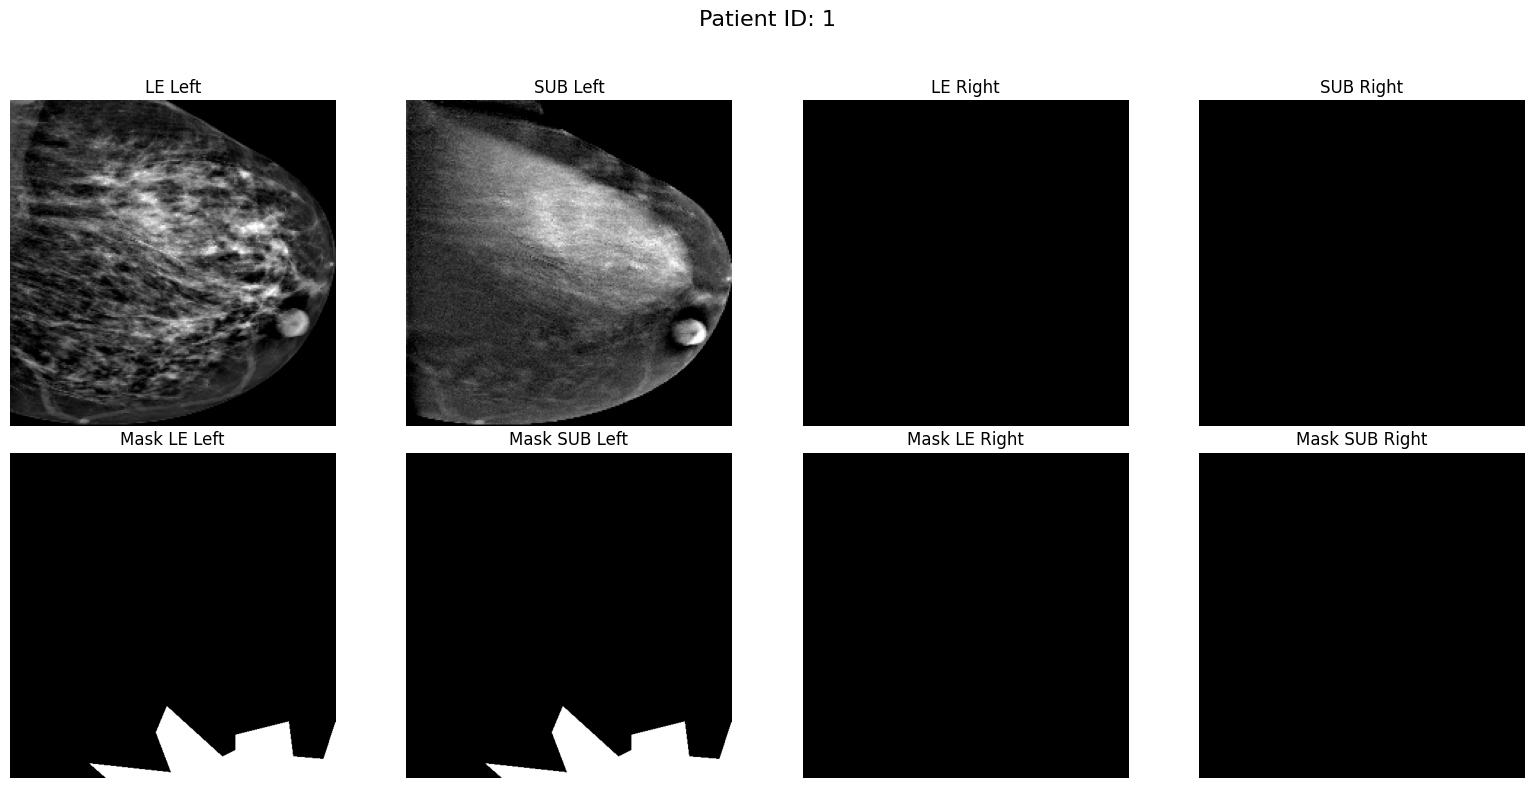

Radiology Report:
{
    "patient_id": "1",
    "acr_density": "ACR C: Heterogeneously dense breasts.",
    "examinations": [
        {
            "modality": "Digital Mammography",
            "findings": {
                "right_breast": {},
                "left_breast": {
                    "mass_presence": false,
                    "mass_description": null,
                    "skin_retraction": false,
                    "nipple_retraction": false,
                    "birads": null,
                    "raw_text": "Upper architectural distortion is seen.\nNo suspicious microcalcifications.\nNormal skin thickness and contour of breast."
                }
            }
        },
        {
            "modality": "Contrast Enhanced Spectral Mammography",
            "findings": {
                "right_breast": {},
                "left_breast": {
                    "mass_presence": true,
                    "mass_description": null,
                    "skin_retraction": false

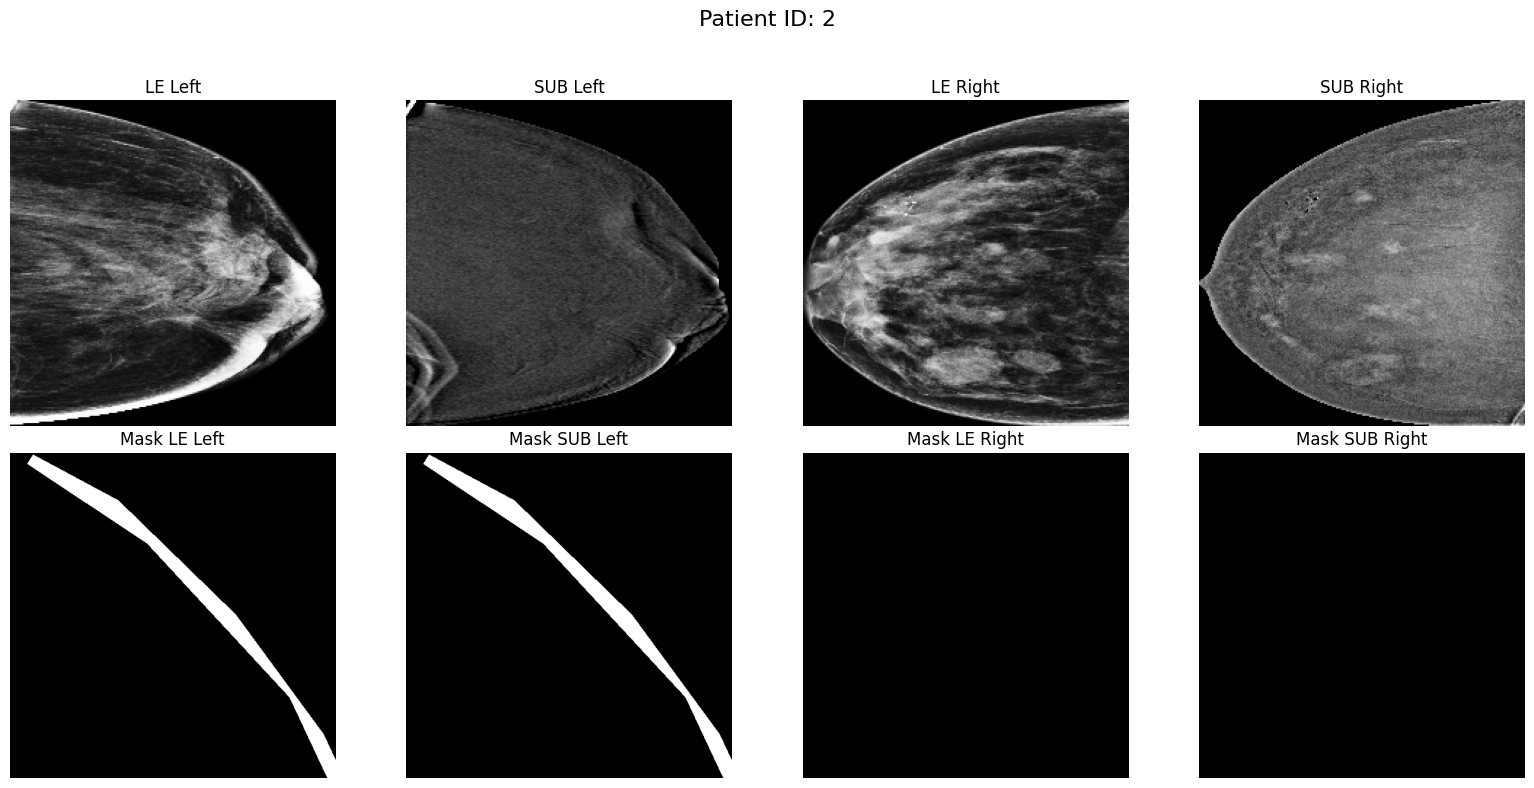

Radiology Report:
{
    "patient_id": "2",
    "acr_density": "ACR C: Heterogeneously dense breasts.",
    "examinations": [
        {
            "modality": "Digital Mammography",
            "findings": {
                "right_breast": {
                    "mass_presence": true,
                    "mass_description": "masses are seen, some of them show circumscribed margin and others show obscured margin",
                    "skin_retraction": false,
                    "nipple_retraction": false,
                    "birads": null,
                    "raw_text": "ACR C: Heterogeneously dense breasts.\nUpper outer quadrant benign macrocalifications.\nNo suspicious microcalcifications.\nMultiple lower and central inner equal density rounded and oval shaped masses are seen, some of them show circumscribed margin and others show obscured margin.\nNormal skin thickness and contour of breast."
                },
                "left_breast": {
                    "mass_presence": t

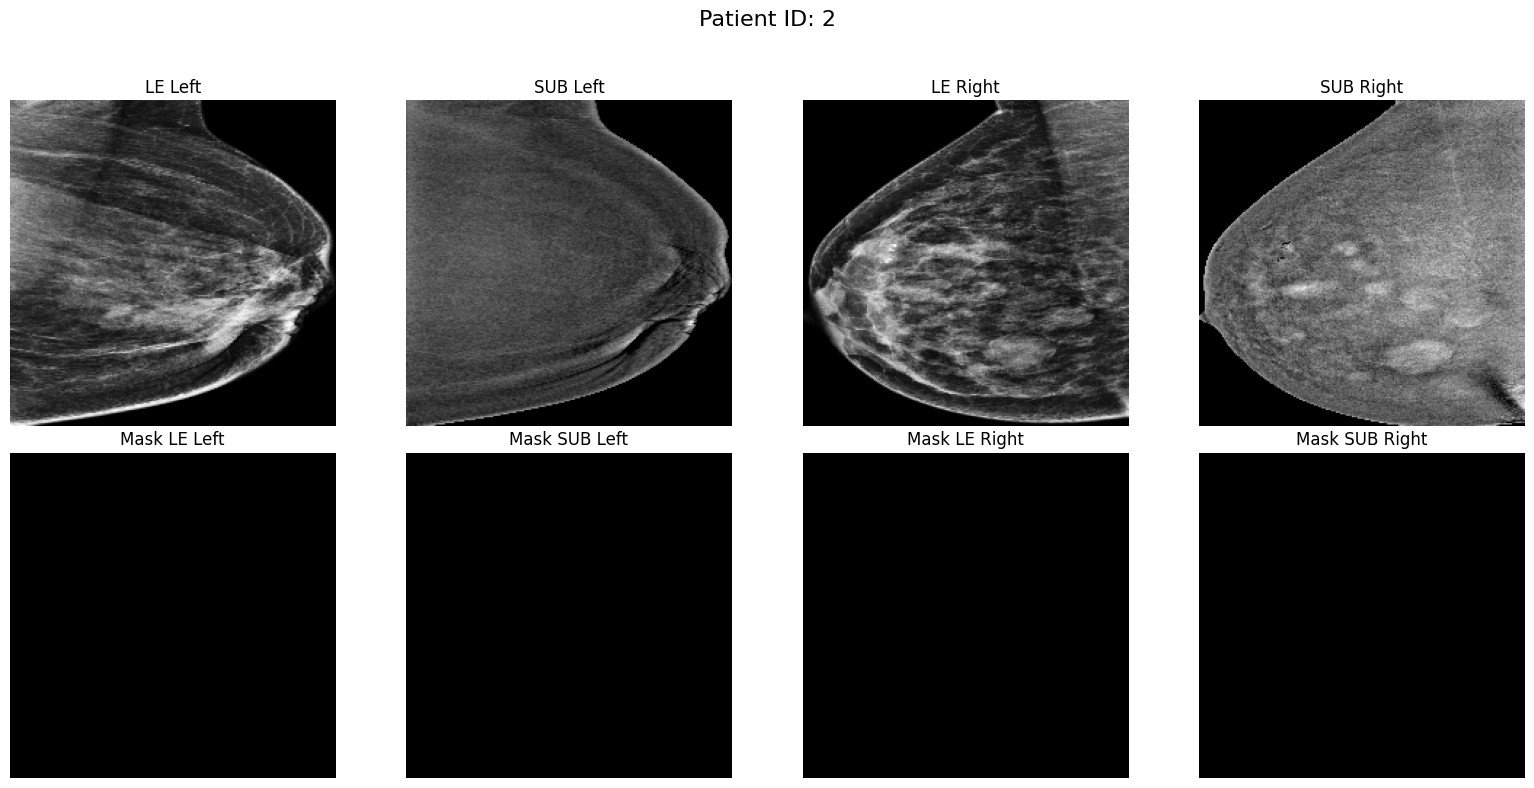

Radiology Report:
{
    "patient_id": "2",
    "acr_density": "ACR C: Heterogeneously dense breasts.",
    "examinations": [
        {
            "modality": "Digital Mammography",
            "findings": {
                "right_breast": {
                    "mass_presence": true,
                    "mass_description": "masses are seen, some of them show circumscribed margin and others show obscured margin",
                    "skin_retraction": false,
                    "nipple_retraction": false,
                    "birads": null,
                    "raw_text": "ACR C: Heterogeneously dense breasts.\nUpper outer quadrant benign macrocalifications.\nNo suspicious microcalcifications.\nMultiple lower and central inner equal density rounded and oval shaped masses are seen, some of them show circumscribed margin and others show obscured margin.\nNormal skin thickness and contour of breast."
                },
                "left_breast": {
                    "mass_presence": t

In [314]:
sample = build_sample(metadata.iloc[1])
if sample:
    display_sample(sample)

sample = build_sample(metadata.iloc[2])
if sample:
    display_sample(sample)

sample = build_sample(metadata.iloc[3])
if sample:
    display_sample(sample)